In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE1786_dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ECE1786_dataset


In [ ]:
!ls
!pwd

final_dataset_suicide_test_10_openai_prepared.jsonl
final_dataset_suicide_test_huggingface.csv
final_dataset_suicide_train_huggingface.csv
mlp.pt
/content/drive/MyDrive/ECE1786_dataset


In [ ]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

This section defines the dataset structure for training, testing and validation.

In [ ]:
# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, data_path):
        df = pd.read_csv(data_path)

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["prompt"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(1 if row.completion == 'suicide' else 0)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

## load dataset
Please run this section before next step. This section creates datasets, find the proper device and download the word vectors. Before loading data, set batch size to 5 (it balances training speed and loss).

In [ ]:
# batch size
batch_size = 128

In [ ]:
torch.manual_seed(2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

### Processing of the data ###
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                            

train_dataset = TextDataset(glove, 'final_dataset_suicide_train_huggingface.csv')
val_dataset = TextDataset(glove, 'final_dataset_suicide_test_huggingface.csv')

train_dataloader = torch.utils.data.DataLoader(
dataset=train_dataset, 
batch_size=batch_size, 
shuffle=False, 
collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
dataset=val_dataset, 
batch_size=batch_size, 
shuffle=False, 
collate_fn=lambda batch: my_collate_function(batch, device))

Using device: cuda


## Model
This section defines the baseline model.

In [ ]:
class BaselineModel(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.embedding = torch.nn.Embedding.from_pretrained(glove.vectors)
        self.linear = torch.nn.Linear(
            in_features=glove.vectors.shape[1],
            out_features=1
        )

    def forward(self, x):
        e = self.embedding(x)
        preds = self.linear(e.mean(axis=0))
        return preds.squeeze(dim=1)

## Train

A training loop to train the model with hyperparameters and components, it returns the trained model and validation loss/accuracy for each epoch for graphing.

In [ ]:
def train_baseline(num_epoch=50, lr=5e-5, train_dataloader=train_dataloader):
    network = BaselineModel().to(device)
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    train_losses, validation_losses = [], []
    train_accs, validation_accs = [], []
    for epoch in range(num_epoch):
        epoch_train_loss = 0
        epoch_validation_loss = 0
        epoch_train_acc = 0
        epoch_validation_acc = 0
        for X, y in train_dataloader:
            network.train()
            optimizer.zero_grad()
            predictions = network(X)
            loss = loss_fn(predictions, y.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

            preds = (torch.sigmoid(predictions) > 0.5).float()
            epoch_train_acc += ((preds == y).sum() / len(y)).item()
        
        for X, y in validation_dataloader:
            network.eval()
            predictions = network(X)
            loss = loss_fn(predictions, y.float())
            epoch_validation_loss += loss.item()
            
            preds = (torch.sigmoid(predictions) > 0.5).float()
            epoch_validation_acc += ((preds == y).sum() / len(y)).item()

        epoch_train_loss /= len(train_dataloader)
        epoch_validation_loss /= len(validation_dataloader)
        epoch_train_acc /= len(train_dataloader)
        epoch_validation_acc /= len(validation_dataloader)

        train_losses.append(epoch_train_loss)
        validation_losses.append(epoch_validation_loss)
        train_accs.append(epoch_train_acc)
        validation_accs.append(epoch_validation_acc)

        print("epoch {} train loss: ".format(epoch), epoch_train_loss)
        print("epoch {} validation loss: ".format(epoch), epoch_validation_loss)
        print("epoch {} train acc: ".format(epoch), epoch_train_acc)
        print("epoch {} validation acc: ".format(epoch), epoch_validation_acc)

    print('Finished Training')

    return network, train_losses, validation_losses, train_accs, validation_accs

## 4.5 Full Training Data

Train a model with required hyperparameters (5 epochs, learning rate 0.00001) and the train dataset. Then plot the train and validation accruacy/loss. After training, this section tests the accuracy and loss on the test dataset.

In [ ]:
network, train_losses, validation_losses, train_accs, validation_accs = train_baseline()

epoch 0 train loss:  0.6976477310159132
epoch 0 validation loss:  0.6891030417971833
epoch 0 train acc:  0.5019060643762893
epoch 0 validation acc:  0.5147800032309321
epoch 1 train loss:  0.6832007911634203
epoch 1 validation loss:  0.6776875231501668
epoch 1 train acc:  0.5584976929691007
epoch 1 validation acc:  0.583599075328472
epoch 2 train loss:  0.6722590291665057
epoch 2 validation loss:  0.6674776125785916
epoch 2 train acc:  0.6145808500090569
epoch 2 validation acc:  0.6235715717423794
epoch 3 train loss:  0.662602363584342
epoch 3 validation loss:  0.6585523219302644
epoch 3 train acc:  0.6426785375545777
epoch 3 validation acc:  0.6454514271991197
epoch 4 train loss:  0.6541735998748952
epoch 4 validation loss:  0.6507745234425678
epoch 4 train acc:  0.6587965226659614
epoch 4 validation acc:  0.6593958312688872
epoch 5 train loss:  0.6468159458711906
epoch 5 validation loss:  0.6439804284032001
epoch 5 train acc:  0.6691297346106082
epoch 5 validation acc:  0.66860700052

In [ ]:
num_epoch = 50

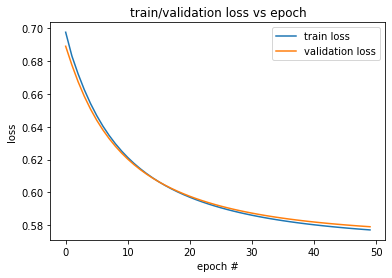

In [ ]:
plt.figure()
plt.plot(range(num_epoch), train_losses, label="train loss")
plt.plot(range(num_epoch), validation_losses, label="validation loss")
plt.title("train/validation loss vs epoch")
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.legend()

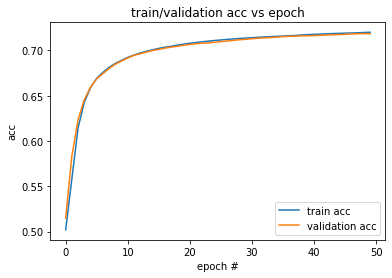

In [ ]:
plt.figure()
plt.plot(range(num_epoch), train_accs, label="train acc")
plt.plot(range(num_epoch), validation_accs, label="validation acc")
plt.title("train/validation acc vs epoch")
plt.xlabel("epoch #")
plt.ylabel("acc")
plt.legend()

## Test

In [ ]:
train_dataset[0][0].view(-1, 1).shape

torch.Size([49, 1])

In [ ]:
torch.sigmoid(network(train_dataset[0][0].view(-1, 1).to(device)))

tensor([0.9999], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
def test_baseline(network):
    loss_fn = torch.nn.BCEWithLogitsLoss()

    epoch_test_loss = 0
    epoch_test_acc = 0
    for X, y in test_dataloader:
        predictions = network(X)
        loss = loss_fn(predictions, y.float())
        epoch_test_loss += loss.item()

        preds = (torch.sigmoid(predictions) > 0.5).float()
        epoch_test_acc += ((preds == y).sum() / len(y)).item()
    
    epoch_test_loss /= len(test_dataloader)
    epoch_test_acc /= len(test_dataloader)
    
    print("final test loss: {}".format(epoch_test_loss))
    print("final test acc: {}".format(epoch_test_acc))

    print('Finished Testing')

In [ ]:
test_baseline(network)

final test loss: 0.27616305982810446
final test acc: 0.8930000060424209
Finished Testing


## 4.7 Saving and loading your model

Save the model for later use. Since my model did not overfit from the result, I just saved the model trained after the last epoch, which achieves the lowest validation loss.

In [ ]:
torch.save(network.state_dict(), 'mlp.pt')